In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/RESEARCH/QML_ADNI/AD'

Mounted at /content/drive
/content/drive/My Drive/RESEARCH/QML_ADNI/AD


In [ ]:
!pip install qiskit

In [ ]:
!pip install qiskit-aer

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit_aer import Aer

from glob import glob

In [ ]:
from glob import glob
#define size to which images are to be resized
IMAGE_SIZE = [128, 128] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
AD_path = 'Mild_Demented'
CT_path = 'Non_Demented'

# Use glob to grab images from path .jpg or jpeg
AD_files = glob(AD_path + '/*')
CT_files = glob(CT_path + '/*')

In [ ]:
def rgb_to_gray(rgb_image):
    # Convert RGB image to grayscale using luminance method
    gray_image = np.dot(rgb_image[...,:3], [0.2989, 0.5870, 0.1140])

    # Convert to uint8 type
    gray_image = gray_image.astype(np.uint8)

    return gray_image

In [ ]:
from os import ctermid
# Preparing Labels
AD_labels = []
CT_labels = []

AD_images=[]
CT_images=[]

import cv2

for i in range(100):
  image = cv2.imread(AD_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(28,28))
  image = rgb_to_gray(image)
  AD_images.append(image)
  AD_labels.append(1)
for i in range(100):
  image = cv2.imread(CT_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(28,28))
  image = rgb_to_gray(image)
  CT_images.append(image)
  CT_labels.append(0)

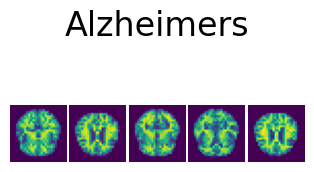

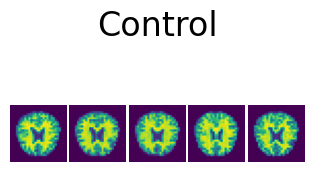

In [ ]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 1, 5
    figsize = [3, 2]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(AD_images, 'Alzheimers')
plot_images(CT_images, 'Control')

In [ ]:
# normalize to interval of [0,1]
AD_images = np.array(AD_images) / 255
CT_images = np.array(CT_images) / 255

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
AD_x_train, AD_x_test, AD_y_train, AD_y_test = train_test_split(
    AD_images, AD_labels, test_size=0.2)
CT_x_train, CT_x_test, CT_y_train, CT_y_test = train_test_split(
    CT_images, CT_labels, test_size=0.2)


X_train = np.concatenate((CT_x_train, AD_x_train), axis=0)
X_test = np.concatenate((CT_x_test, AD_x_test), axis=0)
y_train = np.concatenate((CT_y_train, AD_y_train), axis=0)
y_test = np.concatenate((CT_y_test, AD_y_test), axis=0)

# make labels into categories - either 0 or 1
#y_train = LabelBinarizer().fit_transform(y_train)
#y_train = to_categorical(y_train)

#y_test = LabelBinarizer().fit_transform(y_test)
#y_test = to_categorical(y_test)

In [ ]:
class QuantumCircuit:
  def __init__(self, n_qbits, backend, shots):
    self._circuit = qiskit.QuantumCircuit(n_qbits)

    all_qbits = [i for i in range(n_qbits)]
    self.theta = qiskit.circuit.Parameter("theta")

    self._circuit.h(all_qbits)
    self._circuit.barrier()
    self._circuit.ry(self.theta, all_qbits)

    self._circuit.measure_all()

    self.backend = backend
    self.shots = shots

  def run(self, thetas):
    t_qc = transpile(self._circuit,
                      self.backend)
    qobj = assemble(t_qc,
                    shots=self.shots,
                    parameter_binds=[{self.theta: theta} for theta in thetas])
    job = self.backend.run(qobj)
    result = job.result().get_counts()
    counts = np.array(list(result.values()))
    states = np.array(list(result.keys())).astype(float)

    probabilities = counts / self.shots
    expectation = np.sum(states*probabilities)

    return np.array([expectation])


In [ ]:
simulator = Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Expected value for rotation pi 0.55


<ipython-input-180-3206b06e2208>:23: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


┌───┐ ░ ┌───────────┐ ░ ┌─┐
     q: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

In [ ]:
class HybridFunction (Function):
	@staticmethod
	def forward(ctx, input, quantum_circuit, shift):
		ctx.shift = shift
		ctx.quantum_circuit = quantum_circuit

		expectation_z = ctx.quantum_circuit.run(input[0].tolist())
		result = torch. tensor ([expectation_z])
		ctx.save_for_backward (input, result)

		return result

	@staticmethod
	def backward (ctx, grad_output):
		input, expectation_z = ctx.saved_tensors
		input_list = np.array(input.tolist())

		shift_right = input_list + np.ones(input_list.shape) * ctx.shift
		shift_left = input_list - np.ones(input_list.shape) * ctx.shift

		gradients = []
		for i in range(len(input_list)):
			expectation_right = ctx.quantum_circuit.run(shift_right[i])
			expectation_left = ctx.quantum_circuit.run(shift_left[i])

			gradient = torch.tensor ([expectation_right]) - torch.tensor([expectation_left])
			gradients.append(gradient)
		gradients = np.array([gradients]).T
		return torch.tensor ([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    def __init__(self, backend, shots, shift):
      super(Hybrid, self).__init__()
      self.quantum_circuit = QuantumCircuit(1, backend, shots)
      self.shift = shift

    def forward(self, input):
      return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [ ]:
#Training using first 100 somples

n_samples = 100

X_train = datasets.MNIST(root:='./data', train=True, download=True,
                         transform=transforms.Compose([transforms. ToTensor()]))

#Leaving only labels 0 and 1

idx= np.append(np.where(X_train.targets == 0)[0][:n_samples],
               np.where(X_train.targets == 1) [0] [:n_samples])

X_train.data = X_train.data[idx]

X_train.targets = X_train.targets [idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

In [ ]:
#To display how the input data Looks

n_samples_show = 6

data_iter = iter(train_loader)

fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
  images, targets = data_iter.__next__()
  axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap="gray")
  axes[n_samples_show - 1].set_xticks([])
  axes[n_samples_show - 1].set_yticks([])
  axes[n_samples_show - 1].set_title("Labeled: {}".format(targets. item()))

  n_samples_show -= 1

In [ ]:
#Testing Data

n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms. ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples],
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]

X_test.targets = X_test.targets [idx]

test_loader = torch.utils.data. DataLoader(X_test, batch_size=1, shuffle=True)

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.dropout = nn.Dropout2d()
    self.fc1 = nn.Linear(256, 64)
    self.fc2 = nn.Linear(64, 1)
    self.hybrid = Hybrid(Aer.get_backend('aer_simulator'), 100, np.pi / 2)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2)
    x = self.dropout(x)
    x = x.view(1, -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = self.hybrid(x)
    return torch.cat((x, 1 - x), -1)

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()

for epoch in range(epochs):
  total_loss = []
  for data, target in zip(X_train, y_train):
    optimizer.zero_grad()
    data = torch.from_numpy(data).unsqueeze(0)
    data = data.float()
    output = model(data)
    target = torch.tensor([target])
    loss = loss_func(output, target)
    loss.backward()
    optimizer.step()

    total_loss.append(loss.item())
  loss_list.append(sum(total_loss)/len(total_loss))
  print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
      100 * (epoch + 1) / epochs, loss_list[-1]))


<ipython-input-180-3206b06e2208>:23: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Training [5%]	Loss: -0.9481
Training [10%]	Loss: -0.9181
Training [15%]	Loss: -0.8922
Training [20%]	Loss: -0.8759
Training [25%]	Loss: -0.9029
Training [30%]	Loss: -0.7470
Training [35%]	Loss: -0.9094
Training [40%]	Loss: -0.9504
Training [45%]	Loss: -0.9521
Training [50%]	Loss: -0.9542
Training [55%]	Loss: -0.9541
Training [60%]	Loss: -0.9460
Training [65%]	Loss: -0.9393
Training [70%]	Loss: -0.9453
Training [75%]	Loss: -0.9600
Training [80%]	Loss: -0.9584
Training [85%]	Loss: -0.9528
Training [90%]	Loss: -0.9508
Training [95%]	Loss: -0.9410
Training [100%]	Loss: -0.9507


In [ ]:
model.eval()
with torch.no_grad():

  correct = 0
  for data, target in zip(X_test, y_test):
    data = torch.from_numpy(data).unsqueeze(0)
    data = data.float()
    output = model(data)

    pred = output.argmax(dim=1, keepdim=True)
    target = torch.tensor([target])
    correct += pred.eq(target.view_as(pred)).sum().item()

    loss = loss_func(output, target)
    total_loss.append(loss.item())

  print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
      sum(total_loss) / len(total_loss),
      correct / len(X_test) * 100)
  )

<ipython-input-180-3206b06e2208>:23: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Performance on test data:
	Loss: -0.8606
	Accuracy: 50.1%


<ipython-input-180-3206b06e2208>:23: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


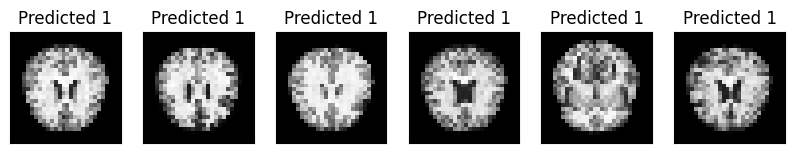

In [ ]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
  for data, target in zip(X_test, y_test):
    if count == n_samples_show:
      break
    data = torch.from_numpy(data).unsqueeze(0)
    data = data.float()
    output = model(data)

    pred = output.argmax(dim=1, keepdim=True)

    axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

    axes[count].set_xticks([])
    axes[count].set_yticks([])
    axes[count].set_title('Predicted {}'.format(pred.item()))

    count += 1

In [ ]:
!pip install qiskit_machine_learning

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

In [ ]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

In [ ]:
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

In [ ]:
train_labels[0]

-1